# Women on Board

### Exploring the Influence of Gender Diversity: Does C25 Stock Performance Correlate with Female Representation on Boards of Directors?

#### I examine the potential connection between the presence of women on boards of directors and the performance metrics of stocks in the C25 index, investigating whether gender diversity plays a role in financial outcomes such as returns and volatility.

To conduct the analysis, I utilize data from finans.dk on the percentage of women on boards in C25 stocks, retrieved on 30 of March, 2023. Additionally, I download data for the stocks and the C25 index using Yahoo Finance.

I explore the datasets by plotting the returns of each stock compared to the C25, visualizing the proportion of women on boards for each company, and comparing the expected return of each stock on the C25 index to the amount of women on boards. Notably, the plot does not seem to yield any correlation between expected returns and the number of women on boards.

Finally, I create a new portfolio weighted by the number of women on boards, assuming that the composition has remained consistent for the past five years. Comparing the new portfolio to the C25 index, I find that weighting the index by women on boards does not underperform compared to the market.

While this is not conclusive evidence that women on boards improve performance, as numerous portfolios could be created from the C25 index, it does not suggest that having women on boards is a detrimental strategy.

Imports and set magics:

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
from matplotlib_venn import venn2
from datetime import datetime

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject as dp

# install yfinance
%pip install yfinance

import yfinance as yf

# install adjustText
%pip install adjustText

from adjustText import adjust_text

# Predefined options for all plots
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 12})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Reading and Cleaning Data

I import a CSV file that includes the companies in the C25 index, a yfinance ticker, and the percentage of female board members for each company.

In [39]:
# read file, sort values descending and reset index
C25F = (pd.read_csv('C25F.csv')
        .sort_values(by =['femaleboard'], ascending=False)
        .reset_index(drop=True))

# display data
C25F.head()

,company,femaleboard,yfinanceticker
0,GN STORE NORD,66.67,GN.CO
1,PANDORA,57.14,PNDORA.CO
2,CHR. HANSEN HOLDING,50.00,CHR.CO
3,COLOPLAST,50.00,COLO-B.CO
4,GENMAB,50.00,GMAB.CO


I generate a list of yfinance tickers to pass as input to yfinance.

In [40]:
# generate a list of yfinance tickers
C25_tickers = list(C25F['yfinanceticker'])

I download historical prices adjusted for dividends, stock splits and offerings from yfinance.

In [41]:
# get historical market data
hist_p = yf.download(C25_tickers, start = '2020-03-01',
                        end = '2023-04-01',
                        interval = '1mo')

# get adjusted close for each stock and change dates
hist_p = hist_p['Adj Close']

# change dates
hist_p.index = hist_p.index.strftime("%m-%y")

# display dataframe
hist_p.head()


[*********************100%***********************]  26 of 26 completed


,AMBU-B.CO,BAVA.CO,CARL-B.CO,CHR.CO,COLO-B.CO,DANSKE.CO,DEMANT.CO,DSV.CO,FLS.CO,GMAB.CO,...,NETC.CO,NOVO-B.CO,NZYM-B.CO,ORSTED.CO,PNDORA.CO,RBREW.CO,ROCK-B.CO,TRYG.CO,VWS.CO,^OMXC25
Date,,,,,,,,,,,,,,,,,,,,,
03-20,164.686874,109.050003,690.846863,488.494751,928.482788,65.811806,150.600006,605.491211,139.733902,1377.0,...,315.225800,383.850800,296.004181,625.472229,197.731430,439.058594,1151.906494,152.197449,108.125114,1126.500000
04-20,212.936554,160.600006,793.157837,563.381897,1013.557556,78.095749,162.750000,691.190857,172.841537,1637.5,...,350.960724,413.202545,319.259674,655.833740,224.828598,471.923035,1339.208496,164.023895,114.699501,1234.959961
05-20,223.204544,200.199997,800.548035,623.291626,1058.730103,80.202789,189.300003,696.503235,175.877228,2060.0,...,406.858917,415.057800,350.649658,749.578735,310.150055,505.910858,1805.066895,132.966751,135.607513,1327.010010
06-20,207.752686,181.300003,809.785828,656.702881,972.064209,85.325401,174.899994,796.650208,184.406082,2220.0,...,434.209106,408.540588,367.014618,729.191101,334.872833,519.854004,1727.129639,135.940430,133.941666,1347.890015
07-20,219.216980,195.300003,857.268188,688.385864,1017.452393,98.199600,195.399994,852.921265,180.743973,2159.0,...,453.174561,396.647827,361.176819,858.376221,371.864044,601.251953,1974.412231,131.763123,160.991791,1423.630005


In [55]:
# calculate monthly returns and cumulative returns
hist_r, hist_cr = dp.calculate_returns(hist_p)

# set the first row of the cumulative returns to 1
hist_cr.iloc[0] = 1

# display dataframe
hist_cr.head()

,AMBU-B.CO,BAVA.CO,CARL-B.CO,CHR.CO,COLO-B.CO,DANSKE.CO,DEMANT.CO,DSV.CO,FLS.CO,GMAB.CO,...,NETC.CO,NOVO-B.CO,NZYM-B.CO,ORSTED.CO,PNDORA.CO,RBREW.CO,ROCK-B.CO,TRYG.CO,VWS.CO,^OMXC25
Date,,,,,,,,,,,,,,,,,,,,,
03-20,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
04-20,1.292978,1.472719,1.148095,1.153302,1.091628,1.186653,1.080677,1.141537,1.236933,1.189179,...,1.113363,1.076467,1.078565,1.048542,1.137040,1.074852,1.162602,1.077705,1.060804,1.096280
05-20,1.355327,1.835855,1.158792,1.275943,1.140280,1.218669,1.256972,1.150311,1.258658,1.496006,...,1.290690,1.081300,1.184610,1.198420,1.568542,1.152263,1.567026,0.873646,1.254172,1.177994
06-20,1.261501,1.662540,1.172164,1.344340,1.046938,1.296506,1.161354,1.315709,1.319695,1.612200,...,1.377454,1.064321,1.239897,1.165825,1.693574,1.184020,1.499366,0.893185,1.238766,1.196529
07-20,1.331114,1.790922,1.240895,1.409198,1.095823,1.492127,1.297477,1.408644,1.293487,1.567901,...,1.437619,1.033339,1.220175,1.372365,1.880652,1.369412,1.714039,0.865738,1.488940,1.263764


## Exploring the Data

To explore the data, I first visualize the cumulative returns of each stock relative to the C25 index.
<br>
Next, I present a bar chart which show the proportion of female board members on each company.

In [58]:
# define type of widget, the options to choose from and the description next to the Dropdown
stockpicker = widgets.Dropdown(options=C25_tickers, description='Stock:')

# display the interactive plot
widgets.interact(dp.cum_ret_plot, data=widgets.fixed(hist_cr), stock=stockpicker, fig = widgets.fixed(1), ax_data=widgets.fixed(None));


interactive(children=(Dropdown(description='Stock:', options=('GN.CO', 'PNDORA.CO', 'CHR.CO', 'COLO-B.CO', 'GM…

Explain what you see when moving elements of the interactive plot around. 

C:\Users\jonas\AppData\Local\Temp\ipykernel_11012\1993699673.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize = 10.5)


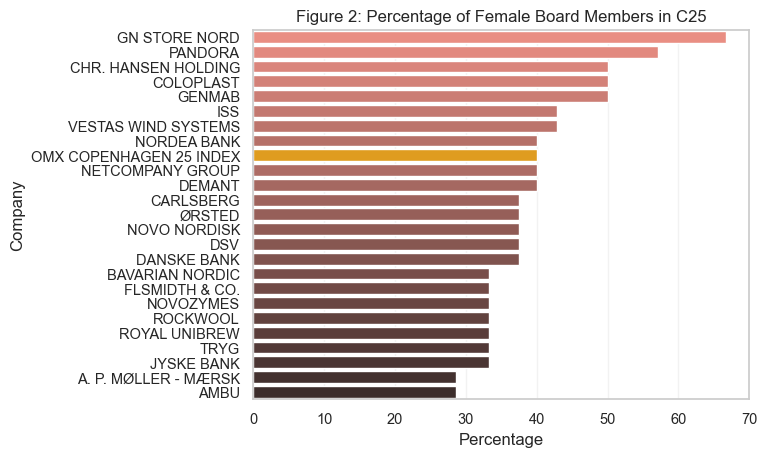

In [44]:
# set theme
sns.set(style="whitegrid")

# create custom color list

# create a list with n colors of dark:salmon_r
palette = list(sns.color_palette('dark:salmon_r', n_colors = len(C25F)))
# insert the color 'orange' in the list of colors using the index of C25
palette.insert(C25F[C25F['company'] == 'OMX COPENHAGEN 25 INDEX'].index[0], 'orange')

# create the bar chart with the custom palette
ax = sns.barplot(x='femaleboard', y='company', data=C25F, palette=palette) 

# set the title, labels and ticks
ax.set_title('Figure 2: Percentage of Female Board Members in C25', fontsize = 12)
ax.set_xlabel('Percentage', fontsize = 12)
ax.set_ylabel('Company', fontsize = 12)

# change the font size of the x- and y-tick labels
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 10.5)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 10.5)

# Show the plot
plt.show();

# Merge data sets

In [45]:
# calculate expected monthly returns, convert to DataFrame, reset index, and rename first column
hist_mark_emr = ((hist_mark_mr.mean()*100)
                 .to_frame(name='emr')
                 .reset_index()
                 .rename(columns={'index': 'yfinanceticker'}))

I merge the datasets `hist_mark_emr` and `C25F`.

In [46]:
femmr = pd.merge(hist_mark_emr,
                C25F,
                on=['yfinanceticker'],
                how='inner')

I create a plot to estimate if there is a connection between the percentage of females on board and the expected monthly return.

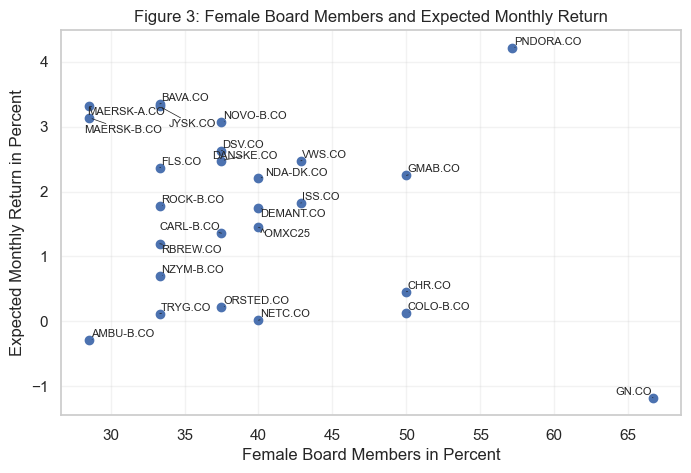

In [47]:
# create variables: 
x = femmr['femaleboard']
y = femmr['emr']
label = femmr['yfinanceticker']

# create the figure
fig = plt.figure()

# set size
fig.set_size_inches(8, 5)

# add plot
ax = fig.add_subplot(1,1,1)
ax.scatter(femmr['femaleboard'], femmr['emr'])

# add a list of text labels for each data point using ax.text and a for loop 
texts = [ax.text(x_pos, y_pos, f'{lab}', fontsize = 8, ha = 'center') for (x_pos, y_pos, lab) in zip(x, y, label)]

# adjust the text labels for each data point automaticly
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k', lw=0.5))

# set title and labels
ax.set_title('Figure 3: Female Board Members and Expected Monthly Return', fontsize = 12)
ax.set_xlabel('Female Board Members in Percent', fontsize = 12)
ax.set_ylabel('Expected Monthly Return in Percent', fontsize = 12)

plt.show();

Comment on connection.

I estimate returns for a index weighted by share of women on the board. 

In [48]:
# remove row with C25 index
wC25F = C25F.loc[C25F['company'] != 'OMX COPENHAGEN 25 INDEX']

# update Maersk A and B by dividing by 2
wC25F.loc[wC25F['yfinanceticker'].isin(['MAERSK-A.CO', 'MAERSK-B.CO']), 'femaleboard'] /= 2

# normalize femaleboard using norm_col func from dataproject.py
wC25F['femaleboard'] = dp.norm_col(wC25F['femaleboard'])

# sort values ascending
wC25F = wC25F.sort_values('yfinanceticker', ascending=True)

# create list for weights
wC25F_list = wC25F['femaleboard'].values.tolist()

C:\Users\jonas\AppData\Local\Temp\ipykernel_11012\305325637.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wC25F['femaleboard'] = dp.norm_col(wC25F['femaleboard'])


In [49]:
# remove column with C25 index
whist_mark_mr = hist_mark_mr.drop(columns = '^OMXC25')

# sort columns ascending
sorted_columns = sorted(whist_mark_mr.columns)
whist_mark_mr = whist_mark_mr[sorted_columns]


In [50]:
# calculate weighted returns
weighted_returns = (wC25F_list * whist_mark_mr)

# calculate portfolio returns 
port_ret = weighted_returns.sum(axis=1)

# calculate cumulative return
cum_port_ret = (1 + port_ret).cumprod()

# convert to dataframe
cum_port_ret = cum_port_ret.to_frame(name='wIndex')

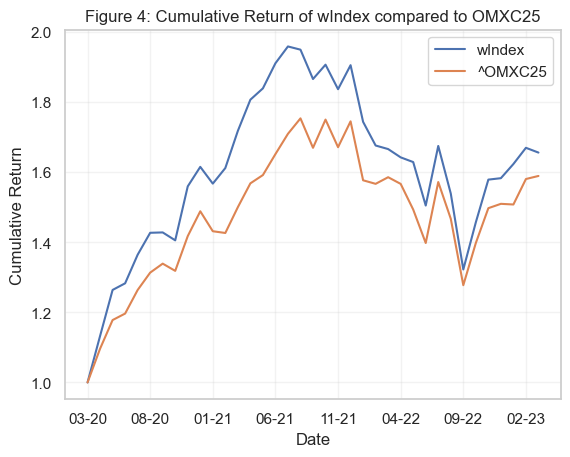

In [51]:
dp.cum_ret_plot(data = hist_mark_cr, stock = 'wIndex', fig = 4, ax_data= cum_port_ret)

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

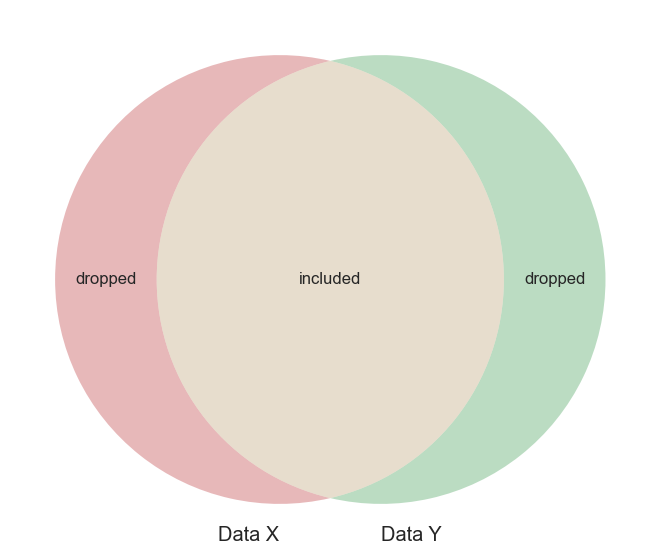

In [52]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.